ATTENZIONE: Ricordati di inserire la tua API key OpenAI nella variabile openai.api_key
Premi Invio per continuare...


Inizializzazione simulazione Asta di Shubik con Agenti AI...
=== INIZIO ASTA DI SHUBIK ===
Regole: Il vincitore paga la sua offerta e vince il premio.
         Il secondo classificato paga la sua offerta ma NON vince nulla!

--- ROUND 1 ---
Premio: 100.0€
Errore API per Marco_Aggressivo: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

Marco_Aggressivo: 27.53€
Errore API per Sara_Conservativa: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `open

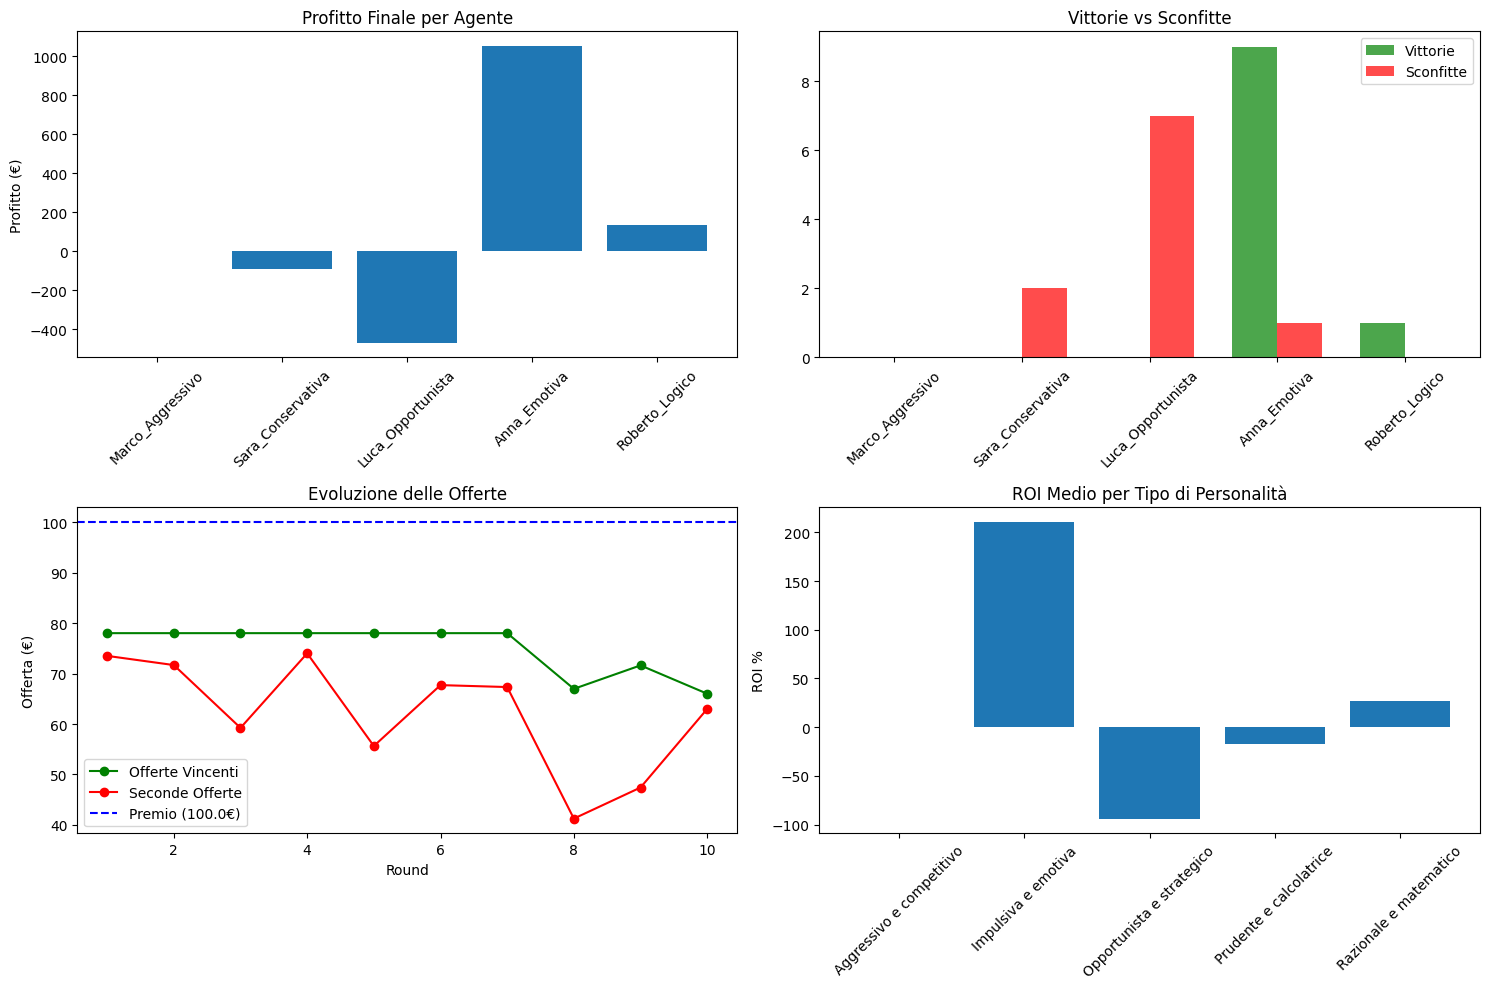


Simulazione completata! Controlla i grafici per l'analisi dettagliata.


In [1]:
import openai
import random
import json
import time
from typing import List, Dict, Any
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
import numpy as np

# Configura la tua API key OpenAI
openai.api_key = "YOUR_OPENAI_API_KEY"  # Sostituisci con la tua API key

@dataclass
class AgentProfile:
    name: str
    personality: str
    risk_tolerance: float  # 0.0 (molto avverso) a 1.0 (molto propenso)
    budget: float
    aggression: float  # 0.0 (passivo) a 1.0 (molto aggressivo)
    description: str

class AIAgent:
    def __init__(self, profile: AgentProfile):
        self.profile = profile
        self.current_budget = profile.budget
        self.bid_history = []
        self.total_spent = 0
        self.wins = 0
        self.losses = 0
        
    def get_ai_decision(self, auction_state: Dict[str, Any]) -> float:
        """Usa OpenAI per decidere l'offerta basata sulla personalità dell'agente"""
        
        prompt = f"""
        Sei un agente nell'asta di Shubik con le seguenti caratteristiche:
        - Nome: {self.profile.name}
        - Personalità: {self.profile.personality}
        - Tolleranza al rischio: {self.profile.risk_tolerance}/1.0
        - Budget rimanente: {self.current_budget:.2f}€
        - Aggressività: {self.profile.aggression}/1.0
        - Descrizione: {self.profile.description}
        
        REGOLE DELL'ASTA:
        - Il premio è di {auction_state['prize']}€
        - Chi fa l'offerta più alta vince il premio ma paga la sua offerta
        - Chi fa la seconda offerta più alta NON vince ma paga comunque la sua offerta
        - Offerta minima: {auction_state['min_bid']}€
        - Offerta attuale più alta: {auction_state['highest_bid']}€ (da {auction_state['highest_bidder']})
        - Seconda offerta più alta: {auction_state['second_highest_bid']}€
        - Round: {auction_state['round']}/{auction_state['max_rounds']}
        
        Le tue statistiche:
        - Vittorie: {self.wins}
        - Sconfitte: {self.losses}
        - Speso finora: {self.total_spent:.2f}€
        
        Basandoti sulla tua personalità e sulla situazione attuale, decidi la tua offerta.
        Considera che:
        1. Se offri troppo poco, potresti finire secondo e pagare senza vincere
        2. Se offri troppo, potresti vincere ma perdere denaro
        3. La tua personalità dovrebbe influenzare la decisione
        
        Rispondi SOLO con un numero (l'importo dell'offerta in euro). 
        Se non vuoi partecipare a questo round, rispondi con 0.
        """
        
        try:
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[{"role": "user", "content": prompt}],
                max_tokens=50,
                temperature=0.7
            )
            
            bid_text = response.choices[0].message.content.strip()
            # Estrai il numero dalla risposta
            bid = float(''.join(filter(lambda x: x.isdigit() or x == '.', bid_text)))
            
            # Applica vincoli logici
            bid = min(bid, self.current_budget)
            bid = max(bid, 0)
            
            return bid
            
        except Exception as e:
            print(f"Errore API per {self.profile.name}: {e}")
            # Fallback: decisione basata su regole semplici
            return self._fallback_decision(auction_state)
    
    def _fallback_decision(self, auction_state: Dict[str, Any]) -> float:
        """Decisione di fallback se l'API non funziona"""
        if self.current_budget < auction_state['min_bid']:
            return 0
        
        # Strategia semplice basata sulla personalità
        max_reasonable_bid = auction_state['prize'] * (0.5 + self.profile.risk_tolerance * 0.4)
        current_high = auction_state['highest_bid']
        
        if current_high >= max_reasonable_bid:
            return 0
        
        increment = (10 + self.profile.aggression * 20) * random.uniform(0.8, 1.2)
        bid = current_high + increment
        
        return min(bid, self.current_budget, max_reasonable_bid)
    
    def place_bid(self, auction_state: Dict[str, Any]) -> float:
        """Piazza un'offerta"""
        if self.current_budget < auction_state['min_bid']:
            return 0
            
        bid = self.get_ai_decision(auction_state)
        self.bid_history.append(bid)
        return bid
    
    def update_after_round(self, won: bool, amount_paid: float):
        """Aggiorna lo stato dopo un round"""
        self.current_budget -= amount_paid
        self.total_spent += amount_paid
        
        if won:
            self.wins += 1
        else:
            self.losses += 1

class ShubikAuction:
    def __init__(self, agents: List[AIAgent], prize: float = 100.0, min_bid: float = 1.0):
        self.agents = agents
        self.prize = prize
        self.min_bid = min_bid
        self.round_number = 0
        self.max_rounds = 10
        self.history = []
        
    def run_auction_round(self) -> Dict[str, Any]:
        """Esegue un singolo round d'asta"""
        self.round_number += 1
        print(f"\n--- ROUND {self.round_number} ---")
        print(f"Premio: {self.prize}€")
        
        # Raccogli le offerte
        bids = []
        for agent in self.agents:
            bid = agent.place_bid({
                'prize': self.prize,
                'min_bid': self.min_bid,
                'highest_bid': max([b[1] for b in bids] + [0]),
                'highest_bidder': max(bids, key=lambda x: x[1])[0].profile.name if bids else "Nessuno",
                'second_highest_bid': sorted([b[1] for b in bids] + [0])[-2] if len(bids) > 1 else 0,
                'round': self.round_number,
                'max_rounds': self.max_rounds
            })
            
            if bid > 0:
                bids.append((agent, bid))
                print(f"{agent.profile.name}: {bid:.2f}€")
            else:
                print(f"{agent.profile.name}: Non partecipa")
        
        if len(bids) == 0:
            print("Nessuna offerta in questo round!")
            return {'winner': None, 'payments': {}}
        
        # Ordina le offerte
        bids.sort(key=lambda x: x[1], reverse=True)
        
        # Determina vincitore e pagamenti
        winner = bids[0][0]
        winner_bid = bids[0][1]
        
        payments = {}
        
        # Il vincitore paga la sua offerta
        payments[winner] = winner_bid
        winner.current_budget += self.prize  # Riceve il premio
        
        # Il secondo classificato paga senza vincere (se esiste)
        if len(bids) > 1:
            second_place = bids[1][0]
            second_bid = bids[1][1]
            payments[second_place] = second_bid
        
        # Aggiorna gli agenti
        for agent, payment in payments.items():
            won = agent == winner
            agent.update_after_round(won, payment)
        
        print(f"\nVincitore: {winner.profile.name} (offerta: {winner_bid:.2f}€)")
        if len(bids) > 1:
            print(f"Secondo: {bids[1][0].profile.name} (offerta: {bids[1][1]:.2f}€, paga senza vincere)")
        
        # Salva la storia
        round_data = {
            'round': self.round_number,
            'winner': winner.profile.name,
            'winner_bid': winner_bid,
            'winner_profit': self.prize - winner_bid,
            'second_bidder': bids[1][0].profile.name if len(bids) > 1 else None,
            'second_bid': bids[1][1] if len(bids) > 1 else 0,
            'total_bids': len(bids)
        }
        self.history.append(round_data)
        
        return {'winner': winner, 'payments': payments, 'bids': bids}
    
    def run_full_auction(self):
        """Esegue un'asta completa"""
        print("=== INIZIO ASTA DI SHUBIK ===")
        print("Regole: Il vincitore paga la sua offerta e vince il premio.")
        print("         Il secondo classificato paga la sua offerta ma NON vince nulla!")
        
        for round_num in range(self.max_rounds):
            result = self.run_auction_round()
            
            if not result['bids']:
                print("Asta terminata: nessuna offerta.")
                break
            
            # Mostra stato agenti
            print("\n--- STATO AGENTI ---")
            for agent in self.agents:
                profit = agent.current_budget - agent.profile.budget + (agent.wins * self.prize)
                print(f"{agent.profile.name}: Budget {agent.current_budget:.2f}€, "
                      f"Speso {agent.total_spent:.2f}€, "
                      f"Vittorie {agent.wins}, "
                      f"Profitto totale: {profit:.2f}€")
            
            time.sleep(1)  # Pausa tra i round
    
    def generate_report(self):
        """Genera un report finale con grafici"""
        print("\n=== REPORT FINALE ===")
        
        # Statistiche per agente
        agent_stats = []
        for agent in self.agents:
            final_profit = agent.current_budget - agent.profile.budget + (agent.wins * self.prize)
            agent_stats.append({
                'Nome': agent.profile.name,
                'Personalità': agent.profile.personality,
                'Budget Iniziale': agent.profile.budget,
                'Budget Finale': agent.current_budget,
                'Speso Totale': agent.total_spent,
                'Vittorie': agent.wins,
                'Sconfitte': agent.losses,
                'Profitto Finale': final_profit,
                'ROI %': (final_profit / agent.profile.budget) * 100
            })
        
        df_stats = pd.DataFrame(agent_stats)
        print(df_stats.to_string(index=False))
        
        # Grafici
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Grafico 1: Profitti finali
        ax1.bar(df_stats['Nome'], df_stats['Profitto Finale'])
        ax1.set_title('Profitto Finale per Agente')
        ax1.set_ylabel('Profitto (€)')
        ax1.tick_params(axis='x', rotation=45)
        
        # Grafico 2: Vittorie vs Sconfitte
        agents_names = df_stats['Nome']
        wins = df_stats['Vittorie']
        losses = df_stats['Sconfitte']
        
        x = np.arange(len(agents_names))
        width = 0.35
        
        ax2.bar(x - width/2, wins, width, label='Vittorie', color='green', alpha=0.7)
        ax2.bar(x + width/2, losses, width, label='Sconfitte', color='red', alpha=0.7)
        ax2.set_title('Vittorie vs Sconfitte')
        ax2.set_xticks(x)
        ax2.set_xticklabels(agents_names, rotation=45)
        ax2.legend()
        
        # Grafico 3: Evoluzione delle offerte nel tempo
        if self.history:
            rounds = [h['round'] for h in self.history]
            winner_bids = [h['winner_bid'] for h in self.history]
            second_bids = [h['second_bid'] for h in self.history if h['second_bid'] > 0]
            
            ax3.plot(rounds, winner_bids, 'go-', label='Offerte Vincenti')
            if second_bids:
                ax3.plot(rounds[:len(second_bids)], second_bids, 'ro-', label='Seconde Offerte')
            ax3.axhline(y=self.prize, color='blue', linestyle='--', label=f'Premio ({self.prize}€)')
            ax3.set_title('Evoluzione delle Offerte')
            ax3.set_xlabel('Round')
            ax3.set_ylabel('Offerta (€)')
            ax3.legend()
        
        # Grafico 4: ROI per personalità
        personality_roi = df_stats.groupby('Personalità')['ROI %'].mean()
        ax4.bar(personality_roi.index, personality_roi.values)
        ax4.set_title('ROI Medio per Tipo di Personalità')
        ax4.set_ylabel('ROI %')
        ax4.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        return df_stats

# Definizione dei profili degli agenti
def create_agent_profiles():
    profiles = [
        AgentProfile(
            name="Marco_Aggressivo",
            personality="Aggressivo e competitivo",
            risk_tolerance=0.8,
            budget=500.0,
            aggression=0.9,
            description="Ama vincere a tutti i costi e odia perdere. Tende a fare offerte molto alte."
        ),
        AgentProfile(
            name="Sara_Conservativa",
            personality="Prudente e calcolatrice",
            risk_tolerance=0.2,
            budget=500.0,
            aggression=0.3,
            description="Molto attenta ai costi, fa solo offerte che ritiene sicure e profittevoli."
        ),
        AgentProfile(
            name="Luca_Opportunista",
            personality="Opportunista e strategico",
            risk_tolerance=0.6,
            budget=500.0,
            aggression=0.7,
            description="Aspetta il momento giusto per colpire, studia gli altri prima di agire."
        ),
        AgentProfile(
            name="Anna_Emotiva",
            personality="Impulsiva e emotiva",
            risk_tolerance=0.7,
            budget=500.0,
            aggression=0.6,
            description="Le sue decisioni sono influenzate dalle emozioni e dalle vittorie/sconfitte precedenti."
        ),
        AgentProfile(
            name="Roberto_Logico",
            personality="Razionale e matematico",
            risk_tolerance=0.4,
            budget=500.0,
            aggression=0.4,
            description="Prende decisioni basate su calcoli precisi di probabilità e valore atteso."
        )
    ]
    return profiles

# Funzione principale per eseguire la simulazione
def run_shubik_simulation():
    print("Inizializzazione simulazione Asta di Shubik con Agenti AI...")
    
    # Crea gli agenti
    profiles = create_agent_profiles()
    agents = [AIAgent(profile) for profile in profiles]
    
    # Crea l'asta
    auction = ShubikAuction(agents, prize=100.0, min_bid=5.0)
    
    # Esegui l'asta
    auction.run_full_auction()
    
    # Genera report
    final_stats = auction.generate_report()
    
    return auction, final_stats

# Per eseguire la simulazione, usa:
if __name__ == "__main__":
    # IMPORTANTE: Sostituisci "YOUR_OPENAI_API_KEY" con la tua vera API key OpenAI
    print("ATTENZIONE: Ricordati di inserire la tua API key OpenAI nella variabile openai.api_key")
    print("Premi Invio per continuare...")
    input()
    
    auction, stats = run_shubik_simulation()
    
    print("\nSimulazione completata! Controlla i grafici per l'analisi dettagliata.")